In [1]:
from coreLib.dataset import DataSet
data_dir       = "/home/rezwanul/Desktop/Apsis_Bangla_Handwritten/synth_DataSet/sourcedata/"
ds=DataSet(data_dir)

#LOG     :All paths found


  1%|          | 12788/1059977 [00:00<00:15, 67095.88it/s]

#LOG     :Processing Dictionary:/home/rezwanul/Desktop/Apsis_Bangla_Handwritten/synth_DataSet/sourcedata/bangla/dictionary.csv


100%|██████████| 10305/10305 [00:00<00:00, 722032.39it/s]


#LOG     :converting int labels to string


  1%|▏         | 5532/370098 [00:00<00:06, 55316.49it/s]

#LOG     :Processing Dictionary:/home/rezwanul/Desktop/Apsis_Bangla_Handwritten/synth_DataSet/sourcedata/english/dictionary.csv


100%|██████████| 5975/5975 [00:00<00:00, 561842.09it/s]


#LOG     :bangla.graphemes


100%|██████████| 200840/200840 [00:00<00:00, 4481195.09it/s]


#LOG     :bangla.numbers


100%|██████████| 72045/72045 [00:00<00:00, 3933490.82it/s]


#LOG     :english.graphemes


100%|██████████| 982/982 [00:00<00:00, 3122673.64it/s]


#LOG     :english.numbers
#LOG     :common.symbols
#LOG     :bangla.fonts
#LOG     :english.fonts
#LOG     :common.background
#LOG     :common.noise.random


100%|██████████| 112763/112763 [00:00<00:00, 4127034.69it/s]


#LOG     :common.noise.sign


100%|██████████| 3240/3240 [00:00<00:00, 4436678.08it/s]


# Rotation

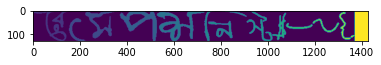

In [177]:
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
import numpy as np
iden=2
from coreLib.word import create_word
img,label,iden=create_word(iden,
                            "bangla",
                            "handwritten",
                            "grapheme",
                            ds,
                            use_dict=True)
# max neutralization
plt.imshow(img)
plt.show()


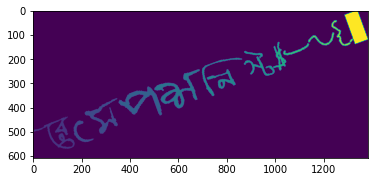

{2: 'রে', 3: 'সে', 4: 'প', 5: 'শ', 6: 'নি', 7: 'স্ট', 8: '$', 9: '-', 10: '~', 11: '{', 12: '.', 13: ' '}
[[ 9.39692621e-01  3.42020143e-01 -3.90127793e-01]
 [-3.42020143e-01  9.39692621e-01  4.87720034e+02]]


In [178]:
def rotate_image(mat, angle):
    """
        Rotates an image (angle in degrees) and expands image to avoid cropping
    """

    height, width = mat.shape[:2] # image shape has 3 dimensions
    image_center = (width/2, height/2) # getRotationMatrix2D needs coordinates in reverse order (width, height) compared to shape

    rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1.)

    # rotation calculates the cos and sin, taking absolutes of those.
    abs_cos = abs(rotation_mat[0,0]) 
    abs_sin = abs(rotation_mat[0,1])

    # find the new width and height bounds
    bound_w = int(height * abs_sin + width * abs_cos)
    bound_h = int(height * abs_cos + width * abs_sin)

    # subtract old image center (bringing image back to origo) and adding the new image center coordinates
    rotation_mat[0, 2] += bound_w/2 - image_center[0]
    rotation_mat[1, 2] += bound_h/2 - image_center[1]

    # rotate image with the new bounds and translated rotation matrix
    rotated_mat = cv2.warpAffine(mat, rotation_mat, (bound_w, bound_h),flags=cv2.INTER_NEAREST)
    return rotated_mat,rotation_mat


rotated_img,M=rotate_image(img,20)
plt.imshow(rotated_img)
plt.show()
print(label)
print(M)
#_img=cv2.resize(_img,(width,font_size)),fx=0,fy=0, interpolation = cv2.INTER_NEAREST)

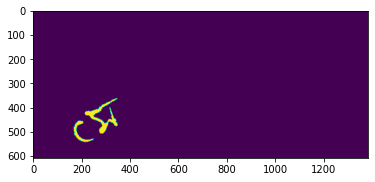

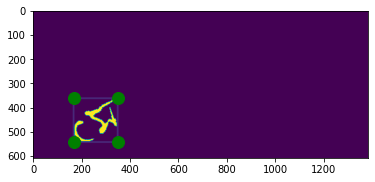

In [179]:
back=np.zeros(rotated_img.shape)
back[rotated_img==3]=255
# back[rotated_img>0]=255
plt.imshow(back)
plt.show()
# co-ordinate
idx = np.where(back==255)
y_min,y_max,x_min,x_max = np.min(idx[0]), np.max(idx[0]), np.min(idx[1]), np.max(idx[1])
x1,x2,x3,x4=x_min,x_max,x_max,x_min
y1,y2,y3,y4=y_min,y_min,y_max,y_max
coords=np.array([[x1,y1],[x2,y2],[x3,y3],[x4,y4]],dtype="float32")

single = cv2.rectangle(back, (x1,y1), (x3,y3), 30, 5)
plt.plot(x1, y1, 'go--', linewidth=2, markersize=12)
plt.plot(x2, y2, 'go--', linewidth=2, markersize=12)
plt.plot(x3, y3, 'go--', linewidth=2, markersize=12)
plt.plot(x4, y4, 'go--', linewidth=2, markersize=12)
plt.imshow(single)
plt.show()

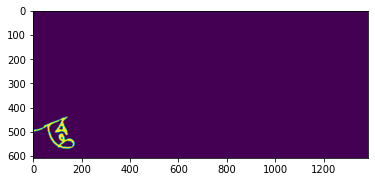

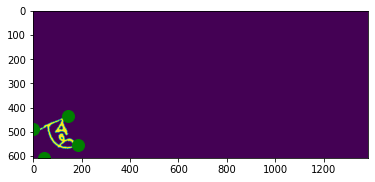

In [180]:
back=np.zeros(rotated_img.shape)
back[rotated_img==2]=255
plt.imshow(back)
plt.show()

mask=np.zeros((rotated_img.shape), np.uint8)

# co-ordinate
idx = np.where(img==2)
y_min,y_max,x_min,x_max = np.min(idx[0]), np.max(idx[0]), np.min(idx[1]), np.max(idx[1])
x1,x2,x3,x4=x_min,x_max,x_max,x_min
y1,y2,y3,y4=y_min,y_min,y_max,y_max

coords=np.array([[x1,y1],[x2,y2],[x3,y3],[x4,y4]],dtype="float32")

new_coords=[]
coord_mat=np.concatenate([coords,np.ones((4,1))],axis=1)
for c in coord_mat:
    new_coords.append(np.dot(M,c))

plt.imshow(back)
for c in new_coords:
    plt.plot(c[0], c[1], 'go--', linewidth=2, markersize=12)

plt.show()

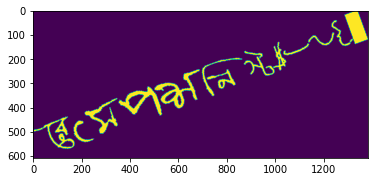

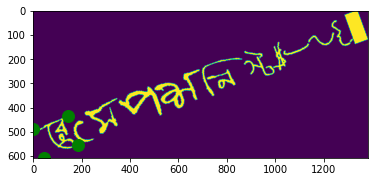

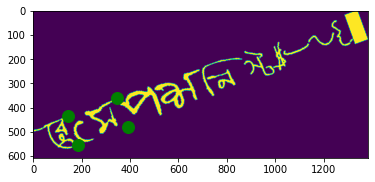

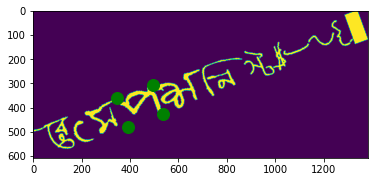

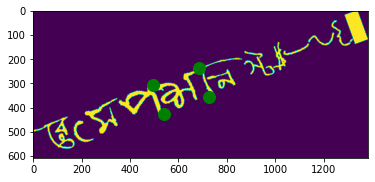

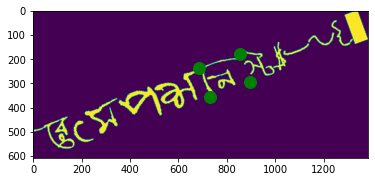

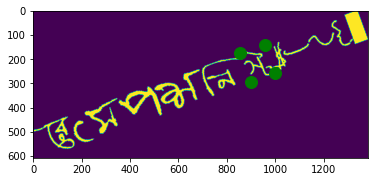

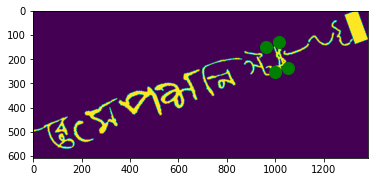

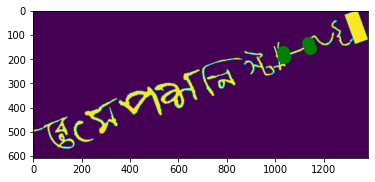

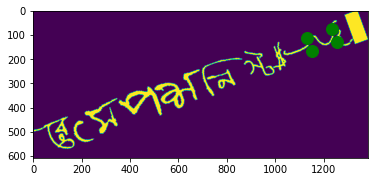

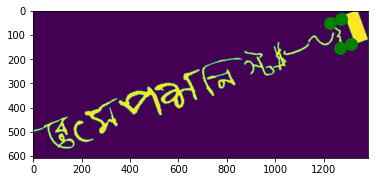

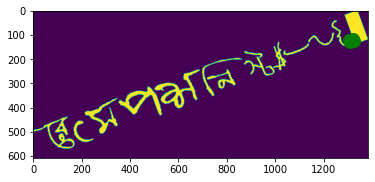

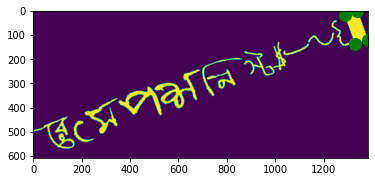

In [181]:
back=np.zeros(rotated_img.shape)
mask=np.zeros(rotated_img.shape)
# back[rotated_img==2]=255
back[rotated_img>0]=255
plt.imshow(back)
plt.show()

Y1,Y2,Y3,Y4,X1,X2,X3,X4=[],[],[],[],[],[],[],[]

for lb in label.keys():
    # co-ordinate
    idx = np.where(img==lb)
    y_min,y_max,x_min,x_max = np.min(idx[0]), np.max(idx[0]), np.min(idx[1]), np.max(idx[1])
    
    x1,x2,x3,x4=x_min,x_max,x_max,x_min
    y1,y2,y3,y4=y_min,y_min,y_max,y_max
    
    X1.append(x1)
    X2.append(x2)
    X3.append(x3)
    X4.append(x4)
    
    Y1.append(y1)
    Y2.append(y2)
    Y3.append(y3)
    Y4.append(y4)
    
    coords=np.array([[x1,y1],[x2,y2],[x3,y3],[x4,y4]],dtype="float32")
#     print(coords)

    new_coords=[]
    coord_mat=np.concatenate([coords,np.ones((4,1))],axis=1)
    for c in coord_mat:
        new_coords.append(np.dot(M,c))
#         print(np.dot(M,c))

    plt.imshow(back)
    for c in new_coords:
        plt.plot(c[0], c[1], 'go--', linewidth=2, markersize=12)
#         print(c[0], c[1])

    plt.show()
    
#     mask[y_min:y_max, x_min:x_max]=255
#     plt.imshow(mask)
#     plt.show()
    

[[   0.    0.]
 [1425.    0.]
 [1425.  127.]
 [   0.  127.]]
-0.39012779319550717 487.72003446090366
1338.671856826724 0.3413302218257286
1382.108415029084 119.68229306163613
43.046430409164415 607.060997300714


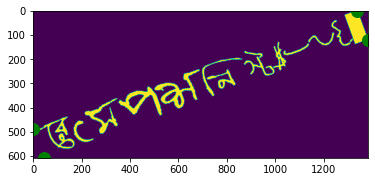

In [182]:
# +++++++++++++++++++++++++++++
x1,x2,x3,x4=min(X1),max(X2),max(X3),min(X4)
y1,y2,y3,y4=min(Y1),min(Y2),max(Y3),max(Y4)

coords=np.array([[x1,y1],[x2,y2],[x3,y3],[x4,y4]],dtype="float32")
print(coords)

new_coords=[]
coord_mat=np.concatenate([coords,np.ones((4,1))],axis=1)
for c in coord_mat:
    new_coords.append(np.dot(M,c))

plt.imshow(back)
for c in new_coords:
    plt.plot(c[0], c[1], 'go--', linewidth=2, markersize=12)
    print(c[0], c[1])

plt.show()

In [183]:
new_coords

[array([-3.90127793e-01,  4.87720034e+02]),
 array([1.33867186e+03, 3.41330222e-01]),
 array([1382.10841503,  119.68229306]),
 array([ 43.04643041, 607.0609973 ])]

In [184]:
np.array(new_coords, np.int32).reshape(-1, 1, 2)

array([[[   0,  487]],

       [[1338,    0]],

       [[1382,  119]],

       [[  43,  607]]], dtype=int32)

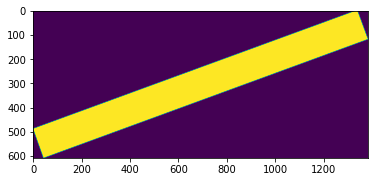

In [185]:
import cv2
import numpy
from matplotlib import pyplot as plt
# mask = np.zeros((475, 696), dtype=np.uint8)
mask=np.zeros((rotated_img.shape), dtype=np.uint8)
pts = np.array(new_coords, np.int32).reshape(-1, 1, 2)
# plt.imshow(cv2.fillPoly(mask,[pts],255), cmap='gray')
mask_=cv2.fillPoly(mask,[pts],255)
plt.imshow(mask_)
plt.show()

In [187]:
# contours, hiearchy = cv2.findContours(mask_, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
# print(contours)

In [188]:
M

array([[ 9.39692621e-01,  3.42020143e-01, -3.90127793e-01],
       [-3.42020143e-01,  9.39692621e-01,  4.87720034e+02]])

In [174]:
# cv2.imwrite('/home/rezwanul/Downloads/back.png',back)


True

In [176]:
# cv2.imwrite('/home/rezwanul/Downloads/mask_.png',mask_)

True

In [175]:
# import cv2

# image = cv2.imread('/home/rezwanul/Downloads/back_img.png')
# copy = image.copy()
# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# thresh = cv2.threshold(gray,0,255,cv2.THRESH_OTSU + cv2.THRESH_BINARY)[1]

# cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# cnts = cnts[0] if len(cnts) == 2 else cnts[1]

# ROI_number = 0
# for c in cnts:
# #     print(c)
#     x,y,w,h = cv2.boundingRect(c)
#     ROI = image[y:y+h, x:x+w]
# #     cv2.imwrite('ROI_{}.png'.format(ROI_number), ROI)
#     cv2.rectangle(copy,(x,y),(x+w,y+h),(36,255,12),2)
#     ROI_number += 1
    
#     plt.imshow(ROI)
#     plt.show()